In [70]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# 기본 기업 리스트 정의
DEFAULT_COMPANIES = {
    'Technology': ['MSFT', 'GOOG', 'META', 'AAPL', 'NVDA', 'CSCO'],
    'Finance': ['BRK.B', 'JPM', 'BAC'],
    'Healthcare': ['LLY', 'JNJ', 'ABBV', 'UNH', 'HCA', 'CI'],
    'Consumer': ['PG', 'KO', 'PM', 'WMT', 'COST', 'MCD', 'DIS'],
    'Energy': ['XOM', 'CVX', 'COP', 'NEE', 'SO', 'DUK'],
    'Industrial': ['FDX', 'UNP', 'UPS', 'MCK', 'COR', 'GWW'],
    'Materials': ['LIN', 'SHW', 'ECL', 'FCX', 'NEM', 'VMC'],
    'Real Estate': ['TSLA', 'GM', 'DHI'],
    'Telecom': ['TMUS', 'T', 'VZ'],
    'Services': ['AMZN', 'BKNG'],
    'Utilities': ['WM', 'RSG', 'WMB']
}

class CPIPredictor:
    def __init__(self, n_pca_comp=5, lags=10, start_date='2020-01-01'):
        """
        CPI 예측 모델 초기화
        
        Args:
            n_pca_comp: PCA 컴포넌트 수
            lags: VAR 모델의 시차
            start_date: 예측 시작 날짜
        """
        self.n_pca_comp = n_pca_comp
        self.lags = lags
        self.start_date = start_date
        self.pca = PCA(n_components=n_pca_comp)
        
    def prepare_data(self, input_df, target_df, lag_days=2):
        """데이터 전처리 및 PCA 변환"""
        # PCA 변환
        reduced_input = self.pca.fit_transform(input_df)
        reduced_df = pd.DataFrame(reduced_input, 
                                index=input_df.index,
                                columns=[f'PC{i+1}' for i in range(self.n_pca_comp)])
        
        # 타겟 데이터 래깅
        target_df = target_df.shift(lag_days)
        
        # 데이터 병합
        self.data = pd.concat([target_df, reduced_df], axis=1).dropna()
        self.data.index.freq = 'B'
        self.start_idx = self.data.index.get_loc(self.start_date)
        
        return self.data

    def train_model(self):
        """VAR 모델 학습"""
        train_data = self.data.iloc[:self.start_idx]
        train_data.index.freq = 'B'
        
        try:
            var_model = VAR(train_data, freq='B')
            self.var_results = var_model.fit(maxlags=self.lags)
            print(f"모델 학습 완료: AIC = {self.var_results.aic}")
            return True
        except Exception as e:
            print(f"VAR 모델 학습 실패: {e}")
            return False

    def predict(self):
        """예측 수행"""
        predictions = []
        actuals = []
        dates = []

        for i in range(self.start_idx, len(self.data)):
            forecast_input = self.data.values[i-self.lags:i]
            var_forecast = self.var_results.forecast(forecast_input, steps=1)
            cpi_pred = var_forecast[0, 0]

            # 변동성 보정
            residuals = self.var_results.resid['CPId']
            vol = residuals.std()
            cpi_pred_adjusted = cpi_pred + np.random.normal(0, vol)

            actual_value = self.data['CPId'].iloc[i]
            pred_date = self.data.index[i]
            
            predictions.append(cpi_pred_adjusted)
            actuals.append(actual_value)
            dates.append(pred_date)

        self.results_df = pd.DataFrame({
            'Date': dates,
            'Actual_CPI': actuals,
            'Predicted_CPI': predictions
        }).set_index('Date')
        
        return self.results_df

    def evaluate(self):
        """모델 성능 평가"""
        total_mae = mean_absolute_error(self.results_df['Actual_CPI'], 
                                      self.results_df['Predicted_CPI'])
        
        naive_pred = self.data['CPId'].shift(1).iloc[self.start_idx:]
        naive_actual = self.data['CPId'].iloc[self.start_idx:]
        mae_naive = mean_absolute_error(naive_actual, naive_pred)
        
        eval_results = {
            'Model MAE': total_mae,
            'Naive MAE': mae_naive,
            'CPI Std': self.data['CPId'].std(),
            'CPI Std * 0.2': self.data['CPId'].std() * 0.2
        }
        
        return eval_results

In [67]:
def plot_experiment_results(results, experiments, true_df):
    """실험 결과 시각화"""
    import scienceplots
    plt.style.use(['science', 'ieee', 'no-latex'])
    years = results[experiments[0]['name']]['results'].index.year.unique()
    n_years = len(years)
    n_experiments = len(experiments)
    
    fig, axes = plt.subplots(n_years, n_experiments, 
                            figsize=(6*n_experiments, 5*n_years),
                            dpi=150)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    for i, year in enumerate(years):
        for j, exp in enumerate(experiments):
            if exp['name'] not in results:
                continue
                
            plot_single_experiment(axes[i, j], results[exp['name']]['results'],
                                true_df, year, exp, i == 0)

    plt.suptitle('CPI Prediction Experiments Comparison\nVAR with PCA', 
                 fontsize=16, y=1.02)
    plt.tight_layout()
    
    return fig, axes

def plot_single_experiment(ax, exp_results, true_df, year, exp, is_first_row):
    """단일 실험 결과 플롯"""
    year_data = exp_results[exp_results.index.year == year]
    year_true = true_df[true_df.index.year == year]
    
    # 병합
    year_data = year_data.join(year_true, how='inner')
    
    # 라인 플롯
    ax.plot(year_data.index, year_data['Actual_CPI'], 
           label='Actual', zorder=3, linestyle='--', color='orange', linewidth=2)
    ax.plot(year_data.index, year_data['Predicted_CPI'], 
           label='Predicted', zorder=2, linestyle='-', color='blue', linewidth=1)
    ax.plot(year_data.index, year_true['CPI_YOY'],
           label='Official', zorder=1, linestyle='-.', color='red', linewidth=1)
    
    # 공시 포인트
    release_points = year_data[year_data['Release']]
    ax.scatter(release_points.index, release_points['CPI_YOY'],
              color='red', s=25, label='Release', zorder=5, marker='*')
    ax.scatter(release_points.index, release_points['Predicted_CPI'],
            color='blue', s=25, label='Release', zorder=5, marker='*')
    # 스타일링
    style_subplot(ax, year, exp, is_first_row)
    
    # MAE 표시
    year_mae = mean_absolute_error(year_data['Actual_CPI'], 
                                 year_data['Predicted_CPI'])
    ax.text(0.02, 0.95, f'MAE: {year_mae:.4f}', 
           transform=ax.transAxes,
           bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8),
           fontsize=8)

def style_subplot(ax, year, exp, is_first_row):
    """서브플롯 스타일링"""
    ax.legend(loc='upper right', fontsize=8)
    if is_first_row:
        ax.set_title(f"{exp['name']}\nReturn: {exp['return_period']}d, Lag: {exp['lag_days']}d", 
                   pad=20, fontsize=10)
    ax.set_xlabel('Date', fontsize=8)
    ax.set_ylabel('CPI YoY (%)', fontsize=8)
    
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, fontsize=8)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=8)

In [68]:
def run_experiments(company_list=None, data_path='Daily물가지수.xlsx'):
    """실험 실행 및 결과 시각화"""
    # 실험 조건 정의
    experiments = [
        {
            'name': 'Exp 1: 5-day Return',
            'return_period': 5,
            'lag_days': 2,
            'n_pca_comp': 5,
            'lags': 5
        },
        {
            'name': 'Exp 2: 20-day Return',
            'return_period': 20,
            'lag_days': 2,
            'n_pca_comp': 5,
            'lags': 5
        },
        {
            'name': 'Exp 3: No Lag',
            'return_period': 5,
            'lag_days': 0,
            'n_pca_comp': 5,
            'lags': 5
        },
        {
            'name': 'Exp 4: More PCA',
            'return_period': 5,
            'lag_days': 2,
            'n_pca_comp': 10,
            'lags': 5
        }
    ]
    
    results = {}
    
    # 실험 수행
    for exp in experiments:
        print(f"\n실행 중: {exp['name']}")
        
        # 각 실험별로 데이터 준비 (수익률 주기 반영)
        input_df, target_df, true_df = prepare_raw_data(
            company_list=company_list,
            data_path=data_path,
            return_period=exp['return_period']
        )
        
        predictor = CPIPredictor(n_pca_comp=exp['n_pca_comp'], lags=exp['lags'])
        data = predictor.prepare_data(input_df, target_df, lag_days=exp['lag_days'])
        
        if predictor.train_model():
            results[exp['name']] = {
                'predictor': predictor,
                'results': predictor.predict(),
                'eval': predictor.evaluate()
            }

    # 결과 시각화
    fig, axes = plot_experiment_results(results, experiments, true_df)
    
    # 성능 비교 출력
    print("\n실험별 성능 비교:")
    for exp_name, exp_data in results.items():
        print(f"\n{exp_name}:")
        for metric, value in exp_data['eval'].items():
            print(f"  {metric}: {value:.6f}")
    
    return fig, axes, results

def prepare_raw_data(company_list=None, data_path='Daily물가지수.xlsx', return_period=5):
    """
    데이터 로드 및 전처리
    
    Args:
        company_list: 사용할 기업 리스트. None이면 기본 리스트 사용
        data_path: 주가 데이터 파일 경로
        return_period: 수익률 계산 기간 (일)
    """
    # 기업 리스트 설정
    if company_list is None:
        company_list = [company for sector in DEFAULT_COMPANIES.values() 
                       for company in sector]

    # 주가 데이터 로드
    price_raw = pd.read_excel(data_path, sheet_name='p', skiprows=13, index_col=0).iloc[6:]
    price_raw.index = pd.to_datetime(price_raw.index)

    # 주가 수익률 계산 (return_period 반영)
    cp_list = [i+'-US' for i in company_list]
    ret = price_raw.loc[:, cp_list].pct_change(return_period, fill_method=None)
    ret.dropna(inplace=True)
    ret.index = pd.to_datetime(ret.index)

    # CPI 데이터 로드
    target_df = pd.read_csv('processed/Approach11.csv', index_col=0, parse_dates=True)
    true_df = target_df.loc[:, ['Release', 'CPI_YOY']]
    true_df = true_df.loc[true_df.index.isin(ret.index)]
    
    # 타겟 변수 준비
    target_df = target_df.loc[:, '10MA']
    target_df.name = 'CPId'

    # 데이터 병합
    input_df = ret.join(target_df, how='inner')
    
    return input_df, target_df, true_df


실행 중: Exp 1: 5-day Return
모델 학습 완료: AIC = -43.52319220685608

실행 중: Exp 2: 20-day Return
모델 학습 완료: AIC = -42.927335708709904

실행 중: Exp 3: No Lag
모델 학습 완료: AIC = -52.233761755430415

실행 중: Exp 4: More PCA
모델 학습 완료: AIC = -80.17824950197337


KeyError: "None of [Index([0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0,\n       0.2, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0,\n       0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.2,\n       0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0],\n      dtype='float64')] are in the [columns]"

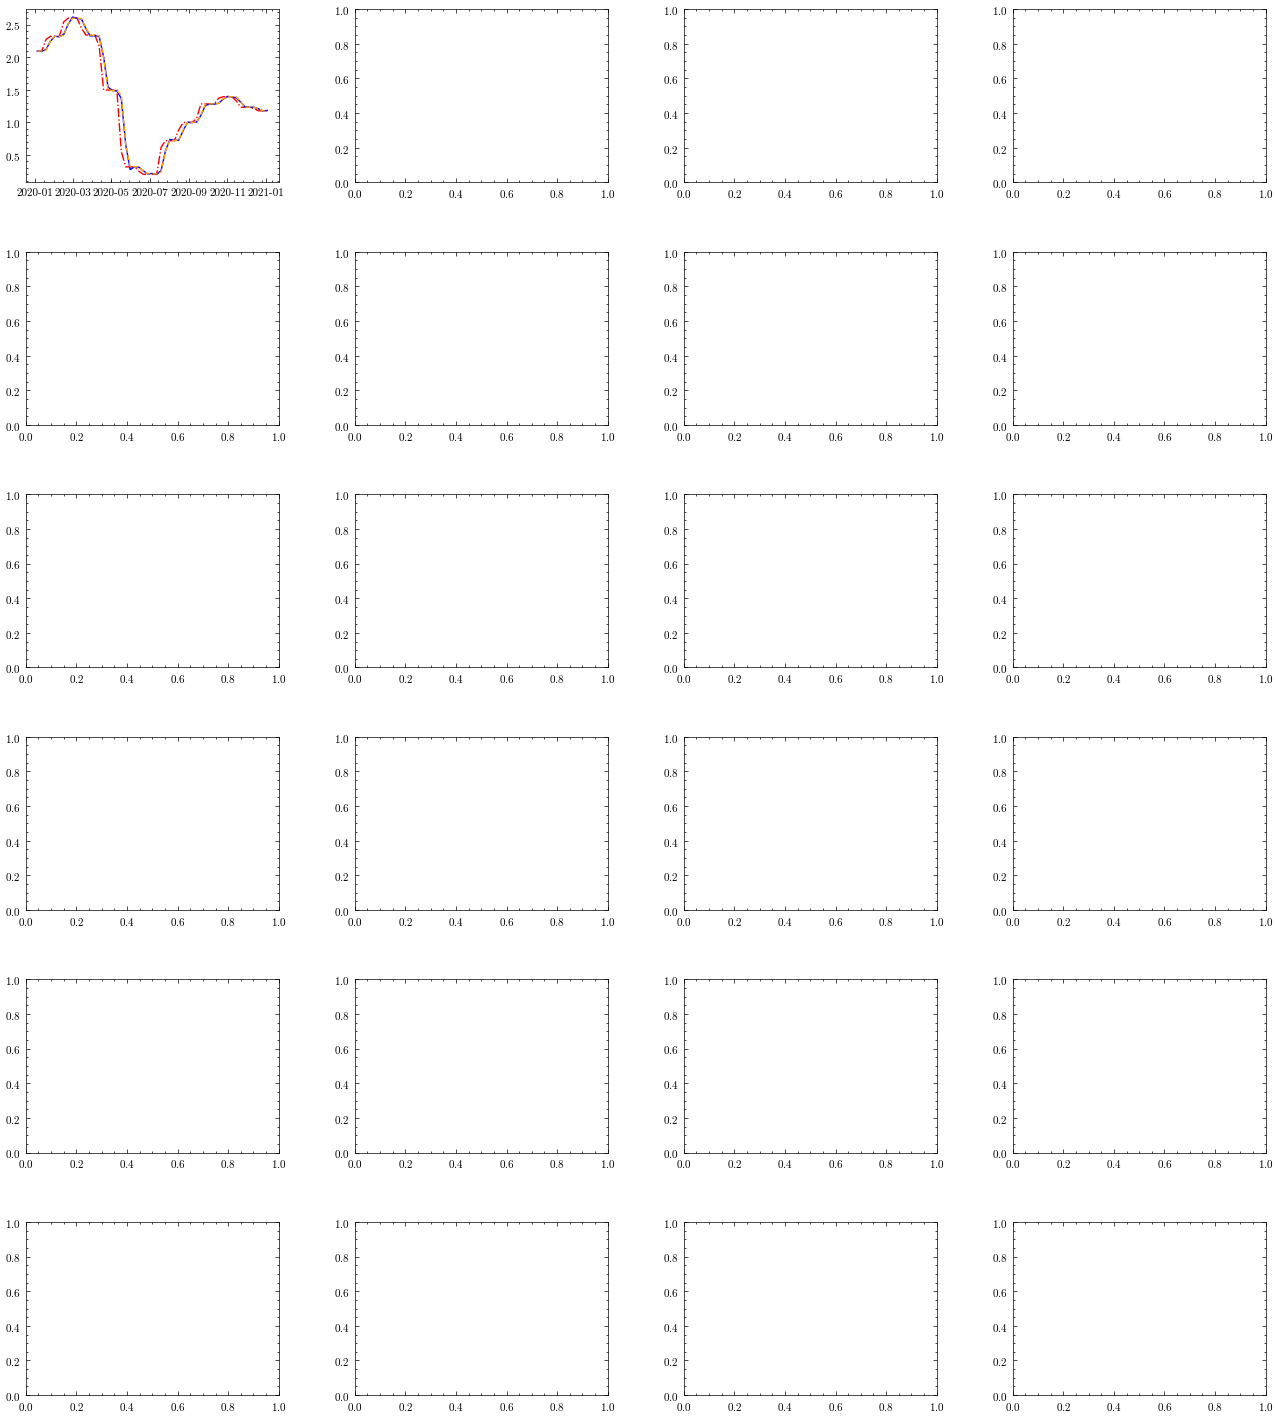

In [69]:
if __name__ == "__main__":
    # 기본 실행 (전체 기업)
    fig, axes, results = run_experiments()
    plt.savefig('Approach2.png')
    # plt.show()

In [41]:
def save_experiment_results(results, save_path='experiment_results.csv'):
    """
    실험 결과를 DataFrame으로 변환하고 CSV로 저장
    
    Args:
        results: 실험 결과 딕셔너리
        save_path: 저장할 CSV 파일 경로
    """
    # 각 실험의 결과를 저장할 리스트
    data_list = []
    
    for exp_name, exp_data in results.items():
        # 예측 결과 데이터 가져오기
        pred_df = exp_data['results']
        
        # 실험 이름 컬럼 추가
        pred_df = pred_df.copy()
        pred_df['Experiment'] = exp_name
        
        # 평가 지표 추가
        for metric, value in exp_data['eval'].items():
            pred_df[metric] = value
            
        data_list.append(pred_df)
    
    # 모든 실험 결과를 하나의 DataFrame으로 통합
    combined_df = pd.concat(data_list, axis=0)
    
    # 인덱스를 컬럼으로 변환
    combined_df = combined_df.reset_index()
    
    # CSV로 저장
    combined_df.to_csv(save_path, index=False, encoding='utf-8-sig')
    print(f"실험 결과가 {save_path}에 저장되었습니다.")
    
    return combined_df

In [42]:
# 결과 저장
results_df = save_experiment_results(results, 'experiment_results.csv')

# 저장된 데이터 확인
print("\n저장된 데이터 미리보기:")
print(results_df.head())

# 실험별 통계 확인
print("\n실험별 평균 MAE:")
print(results_df.groupby('Experiment')['Model MAE'].mean())

실험 결과가 experiment_results.csv에 저장되었습니다.

저장된 데이터 미리보기:
        Date  Actual_CPI  Predicted_CPI           Experiment  Model MAE  \
0 2020-01-01    2.093222       2.068671  Exp 1: 5-day Return   0.014198   
1 2020-01-02    2.093214       2.069557  Exp 1: 5-day Return   0.014198   
2 2020-01-03    2.093206       2.098486  Exp 1: 5-day Return   0.014198   
3 2020-01-06    2.093183       2.087640  Exp 1: 5-day Return   0.014198   
4 2020-01-07    2.093175       2.099256  Exp 1: 5-day Return   0.014198   

   Naive MAE   CPI Std  CPI Std * 0.2  
0   0.016811  2.269265       0.453853  
1   0.016811  2.269265       0.453853  
2   0.016811  2.269265       0.453853  
3   0.016811  2.269265       0.453853  
4   0.016811  2.269265       0.453853  

실험별 평균 MAE:
Experiment
Exp 1: 5-day Return     0.014198
Exp 2: 20-day Return    0.014258
Exp 3: No Lag           0.020862
Exp 4: More PCA         0.014326
Name: Model MAE, dtype: float64


---